In [15]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import pandas as pd
import random
import matplotlib
import sys

from copy import deepcopy

from scipy.interpolate import interp1d
from astropy.cosmology import FlatLambdaCDM

import semlinlens as lens
import func_get_h_eta as h_eta
import func_get_rel as rel

#redirect to wherever pygravlens is stored
sys.path.insert(0,'/home/dilys/pygravlens/')
import pygravlens as gl

In [9]:
plt.rcParams.update({'font.size': 16, 'text.usetex': False})
dpi_set=400
plt.rc('axes', labelsize=16)

from astropy.cosmology import FlatLambdaCDM
cosmo100 = FlatLambdaCDM(H0=100,Om0=0.315)

# source and lens redshift:
zsrc = 0.3
zlens = 2.

#true h where H0=100h km/s/Mpc, and true mass power law slope (1 is isothermal)
h_true = 0.7
eta_true = 1.0

%matplotlib inline
folder = './'

### ENTER NUMBER OF SAMPLES:
n_samples = 10

In [10]:
### FILE NAMES
root = 'mock_'

files = []
datfiles = []

for n in range(1,n_samples+1):
    datfiles.append(folder+root+str(n)+'.dat')
    files.append(folder+root+str(n)+'.txt')

In [16]:
### MCMC FUNCTION - optimizes for source position before analysis
def runlens(basename,ellip=False,eta_range=[0.5,1.5],nopt=100,nwalk=30,nburn=3000,nmain=10000):
    
    # load the lens data
    quad = lens.lens(basename+'.dat',zlens,zsrc,cosmo100)
    # compute the average distance of images from the origin; this is useful for guessing initial conditions
    ravg = np.mean(np.linalg.norm(quad.xarr,axis=1))
    print(f'<r> = {ravg:.3f}')

    # optimize from a bunch of random starting points
    print('Optimizing')
    chibest = 1.0e8
    pbest = []
    for iran in range(nopt):
        # check shear and ellipticity in Gaussian distributions
        gc = np.random.normal(scale=0.05)
        gs = np.random.normal(scale=0.05)
        ec = np.random.normal(scale=0.1)
        es = np.random.normal(scale=0.1)
        # check eta in the specified range
        eta = np.random.uniform(low=eta_range[0],high=eta_range[1])
        # guess b from eta and ravg
        b = ravg**(2.0-eta)
        # always guess h = 0.7
        h = 0.7
        if ellip==False:
            p0 = [0,0,gc,gs,b,eta,h]
        else:
            p0 = [0,0,gc,gs,ec,es,b,eta,h]
        # optimize from this guess
        opt = quad.optimize(p0,mode='fullsum1',ellip=ellip)
        # if this is the best we have found so far, store it
        if opt[1]<chibest:
            pbest = opt[0]
            chibest = opt[1]
            print('best so far:',chibest,pbest)

    print('best optimization:')
    print(pbest)
    print('chisq',chibest)
    
    # run MCMC
    if (nwalk>0) and (nburn>0) and (nmain)>0:
        print('Running MCMC')
        samples = quad.runMC(pstart=pbest,mode='fullsum1',ellip=ellip,nwalk=nwalk,nburn=nburn,nmain=nmain,outname=basename)
        # check optimizing from one of the samples
        print('final optimization:')
        opt = quad.optimize(samples[0],mode='fullsum1',ellip=ellip)
        print(opt[1],opt[0])
    return

Read image data from file mock_1.dat
<r> = 1.042
Optimizing
best so far: 7.513730948652413e-08 [-2.35429553e-02  8.65016120e-02  1.99988386e-01 -4.21409015e-08
  1.00000164e+00  1.00005844e+00  6.99035166e-01]
best so far: 5.248295102329994e-08 [-2.35433609e-02  8.65031034e-02  1.99991772e-01 -3.94523439e-08
  1.00000104e+00  1.00004146e+00  6.99032929e-01]
best so far: 2.5632109007080616e-08 [-2.35434410e-02  8.65037529e-02  1.99993099e-01 -9.43760443e-09
  1.00000122e+00  1.00003515e+00  6.99038749e-01]
best optimization:
[-2.35434410e-02  8.65037529e-02  1.99993099e-01 -9.43760443e-09
  1.00000122e+00  1.00003515e+00  6.99038749e-01]
chisq 2.5632109007080616e-08
Running MCMC
Running MC
emcee burn-in run
emcee main run
final optimization:
6.860461264698741e-08 [-2.35429146e-02  8.65014312e-02  1.99988035e-01  1.15726816e-08
  1.00000161e+00  1.00006036e+00  6.99022784e-01]
final optimization:
6.860461264698741e-08 [-2.35429146e-02  8.65014312e-02  1.99988035e-01  1.15726816e-08
  1.0

best so far: 1.0341480771386899e-08 [-2.65946102e-02 -1.05778352e-02  1.99997363e-01 -3.16026377e-08
  1.00000026e+00  1.00001422e+00  6.99057177e-01]
best so far: 9.515901440570468e-09 [-2.65946030e-02 -1.05778527e-02  1.99997377e-01 -3.49300493e-08
  1.00000024e+00  1.00001429e+00  6.99054866e-01]
best so far: 9.098413409959287e-09 [-2.65947372e-02 -1.05778947e-02  1.99998478e-01 -5.12688213e-08
  1.00000008e+00  1.00000861e+00  6.99057749e-01]
best so far: 7.556799919452236e-09 [-2.65947620e-02 -1.05779155e-02  1.99998605e-01 -4.35966507e-08
  1.00000012e+00  1.00000783e+00  6.99060793e-01]
best so far: 7.318498229460819e-09 [-2.65948143e-02 -1.05779630e-02  1.99999269e-01 -4.09502050e-08
  1.00000004e+00  1.00000437e+00  6.99061966e-01]
best optimization:
[-2.65948143e-02 -1.05779630e-02  1.99999269e-01 -4.09502050e-08
  1.00000004e+00  1.00000437e+00  6.99061966e-01]
chisq 7.318498229460819e-09
Running MCMC
Running MC
emcee burn-in run
emcee main run
final optimization:
1.11181332

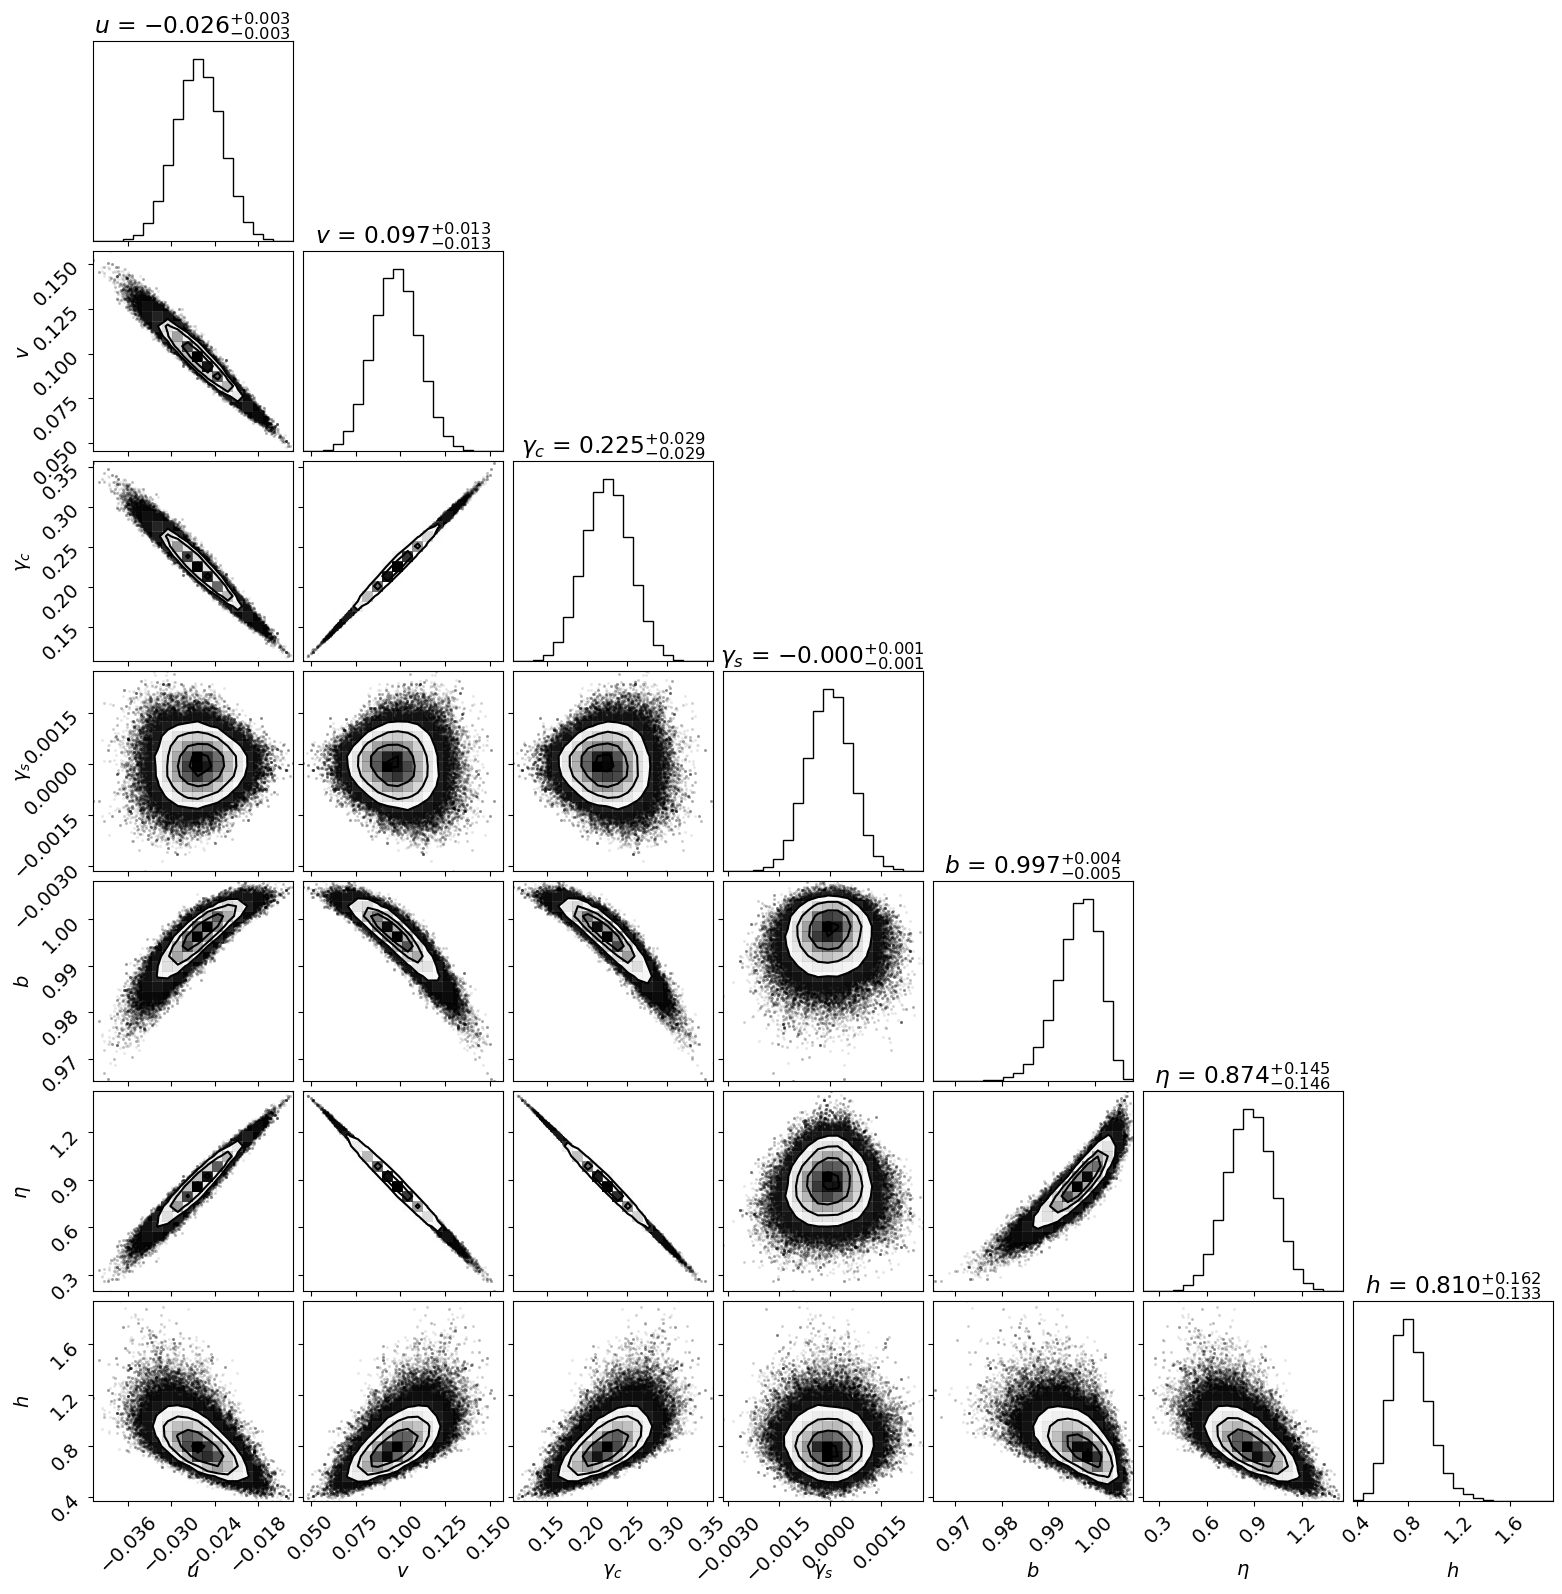

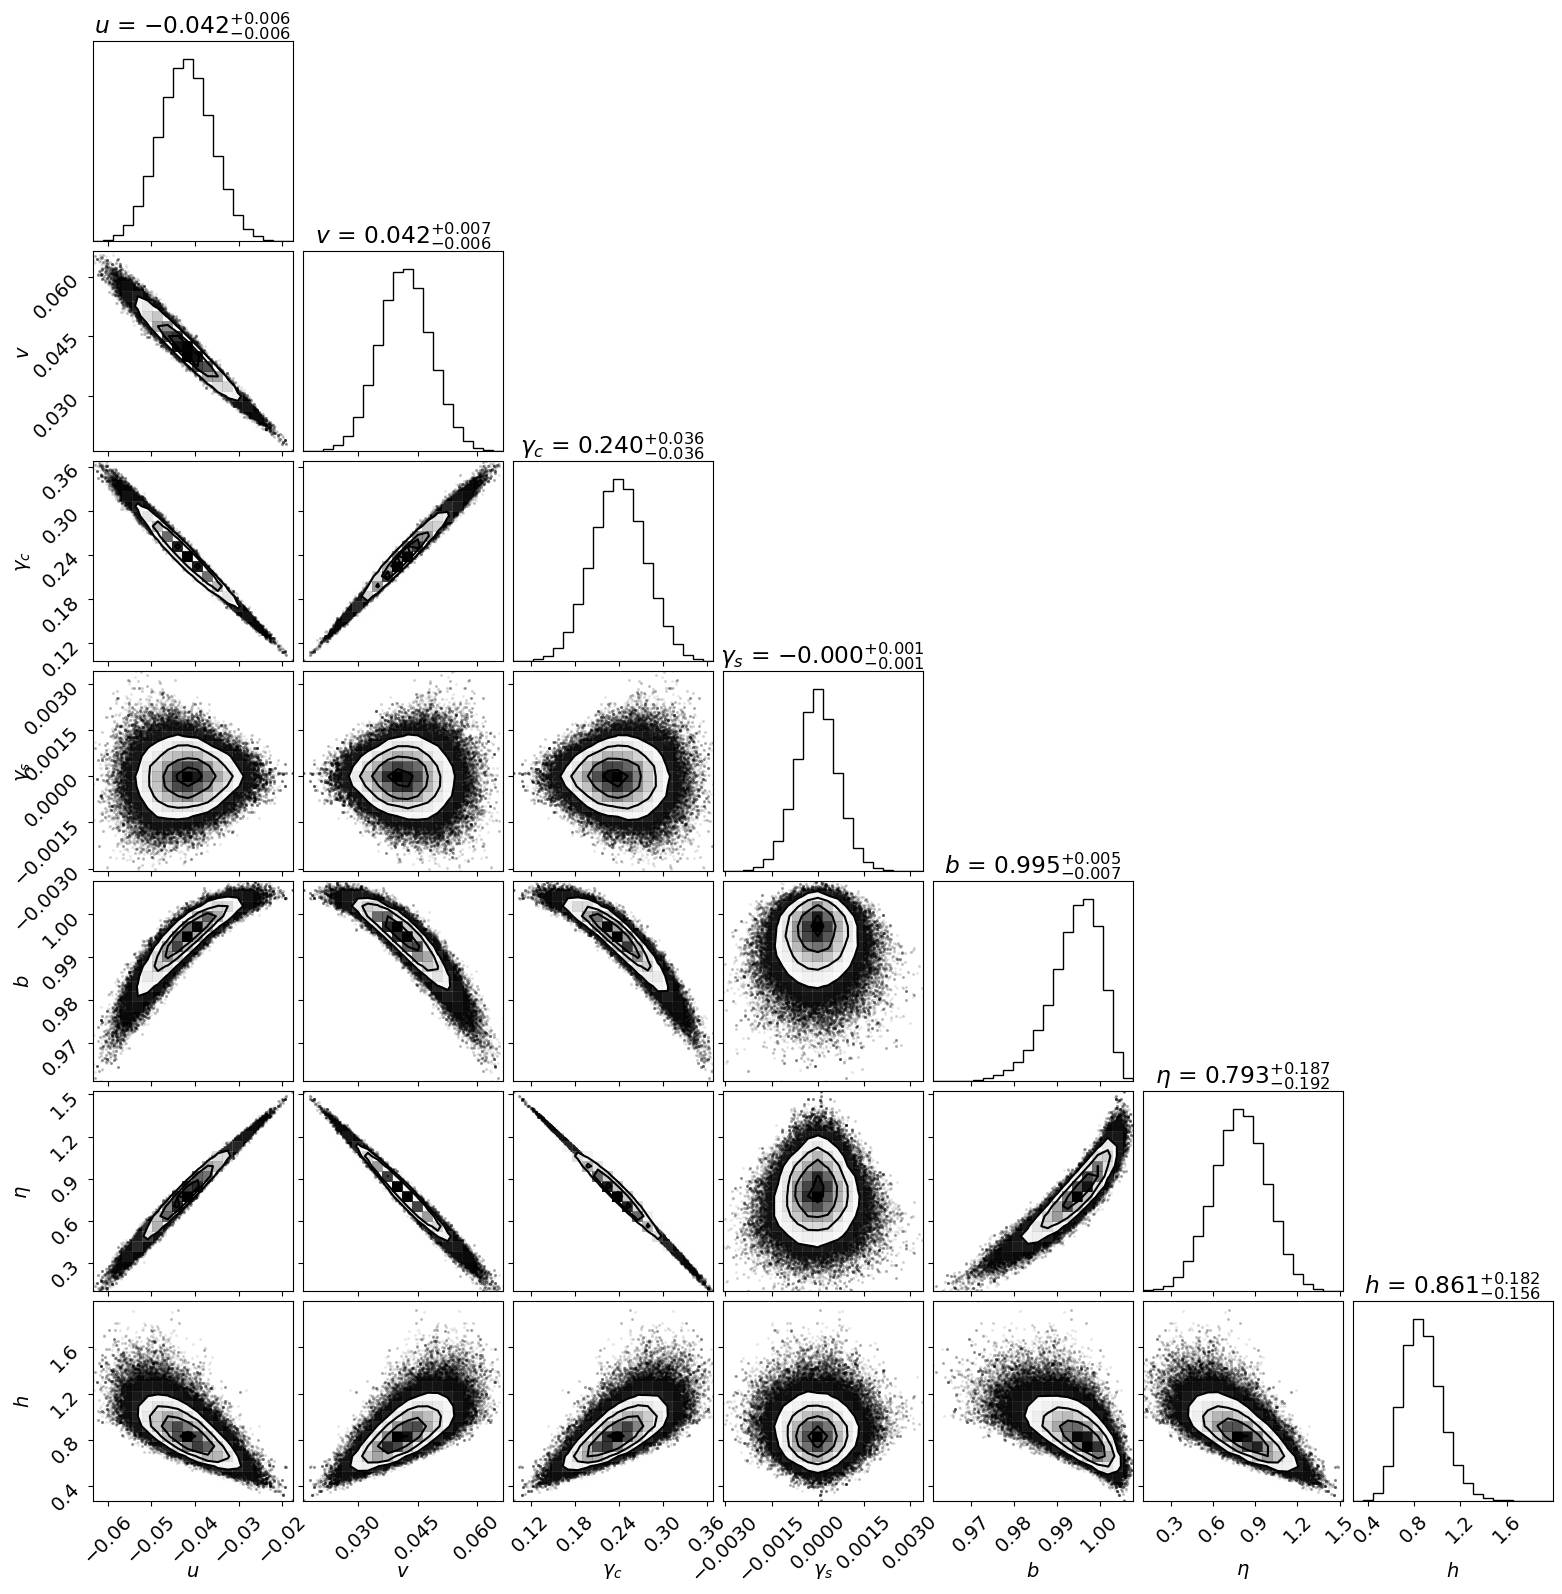

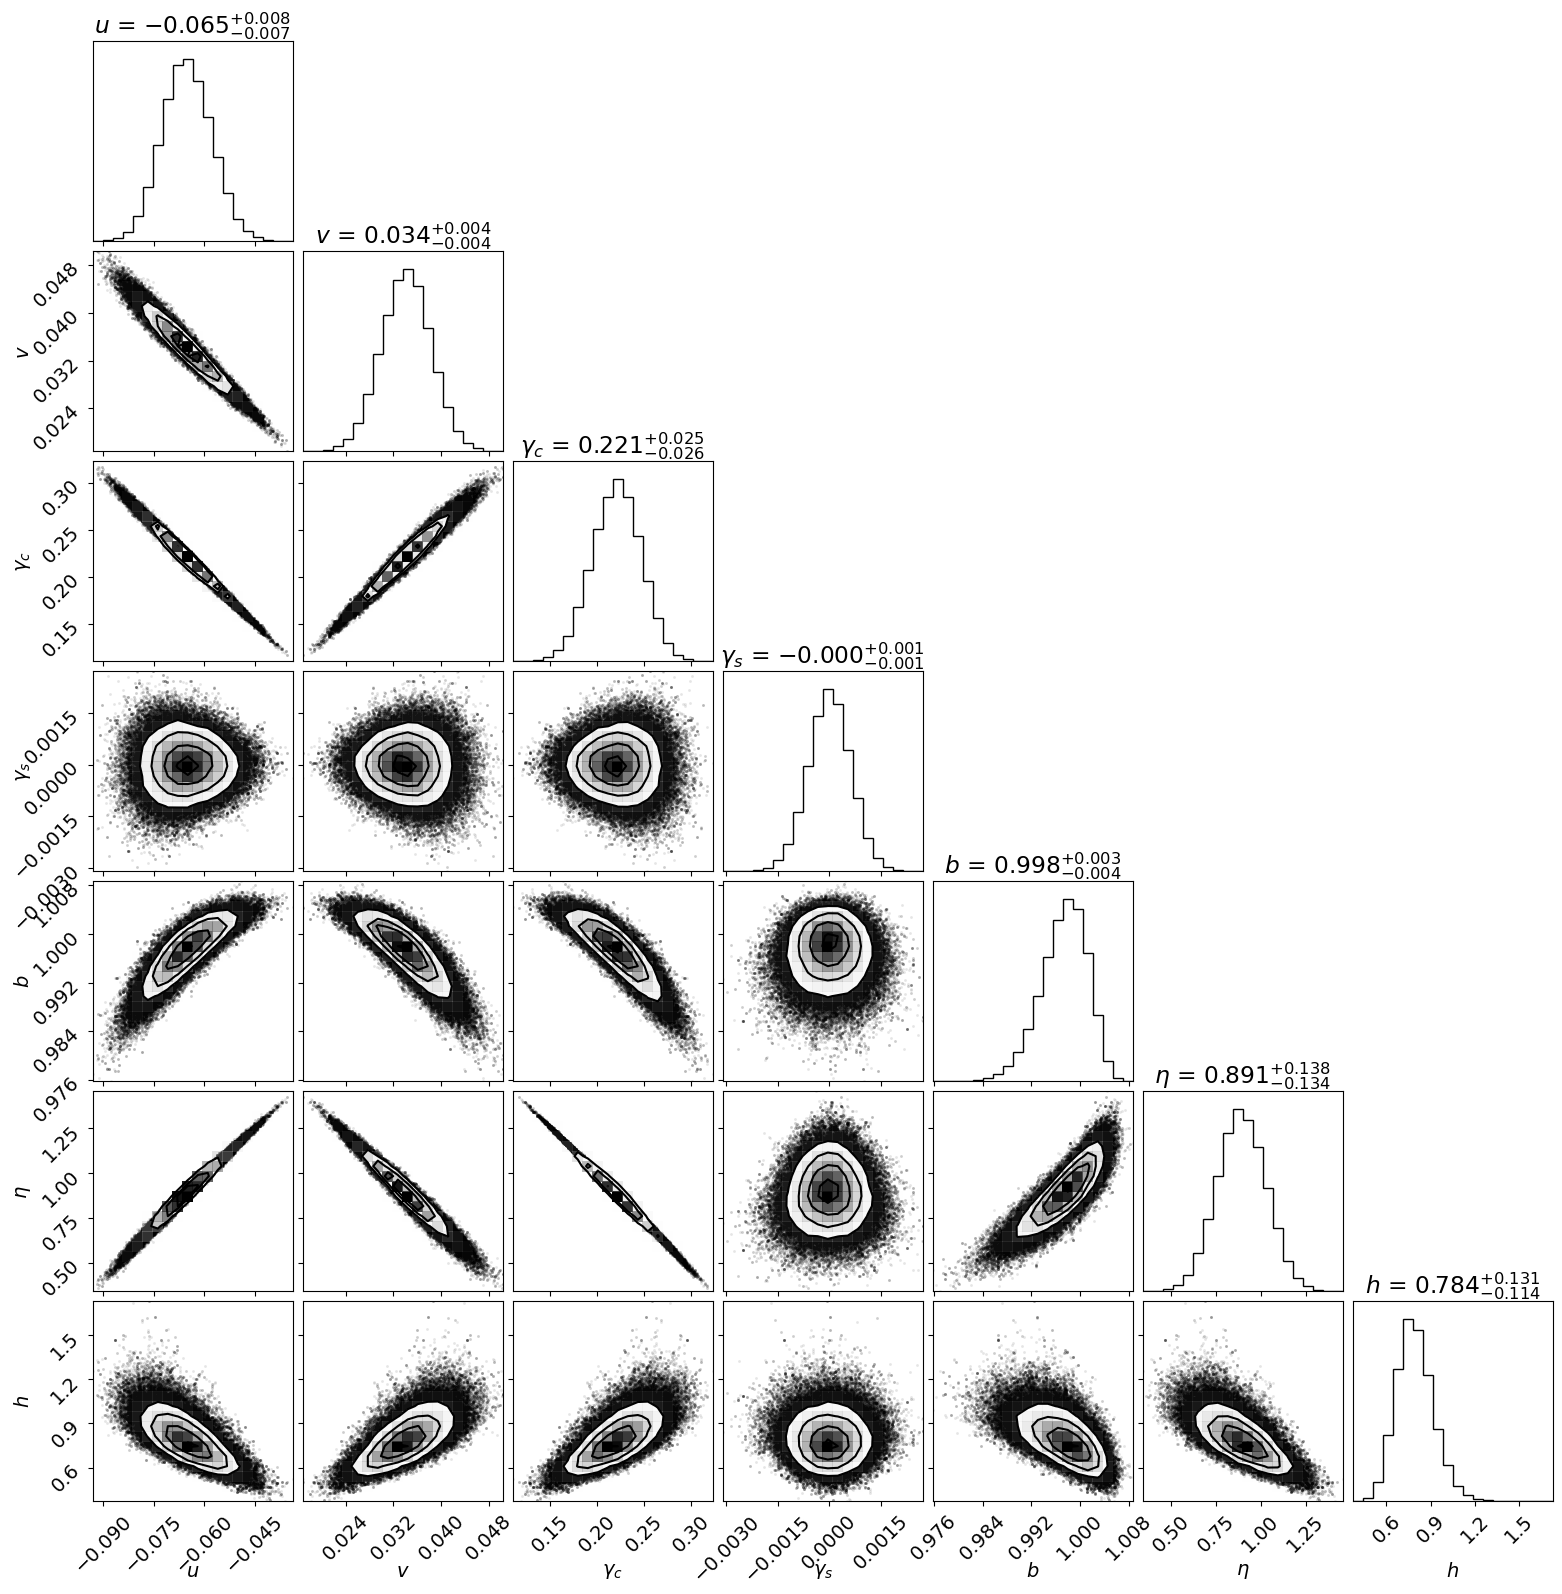

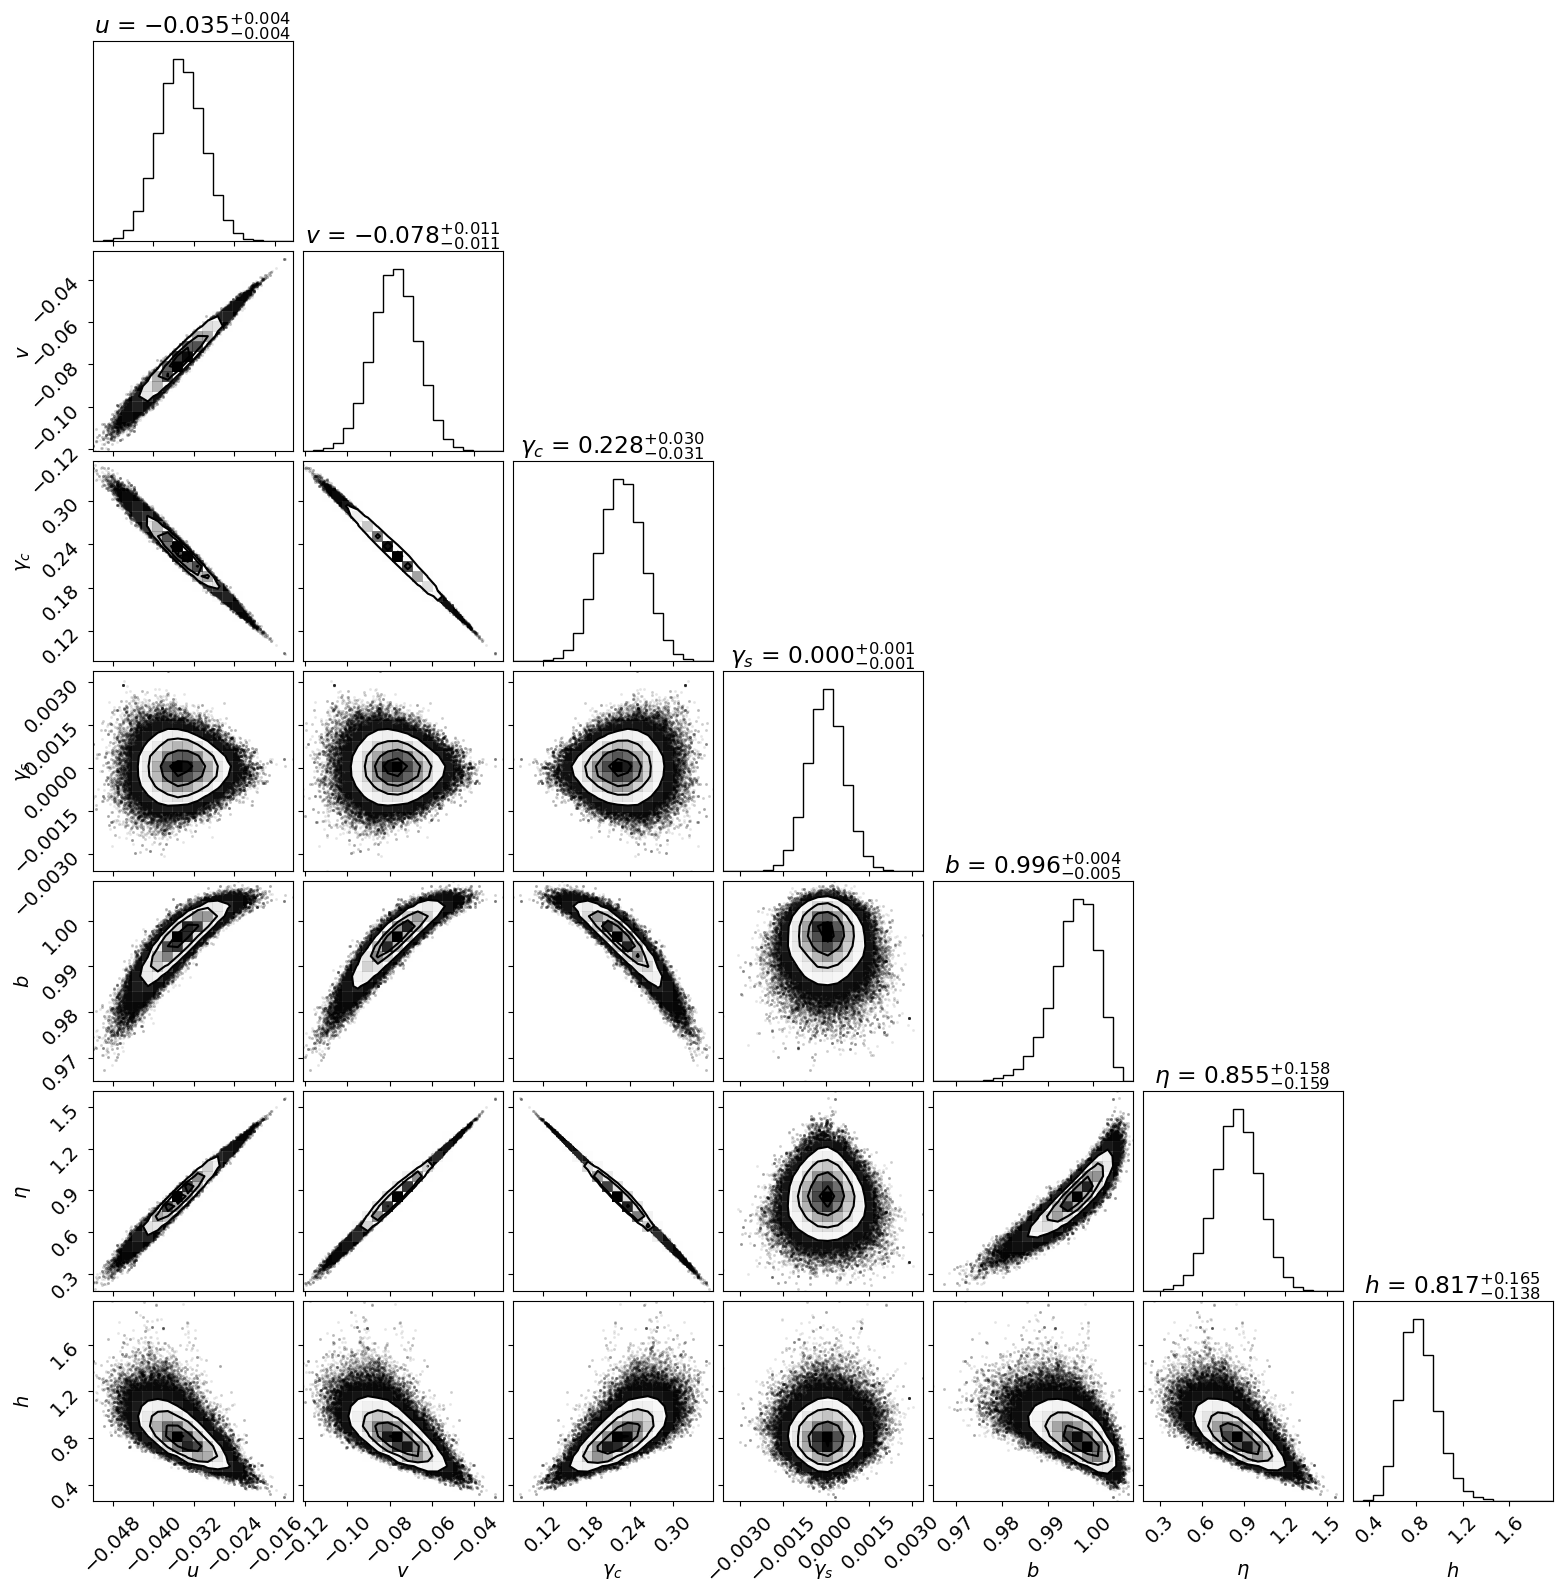

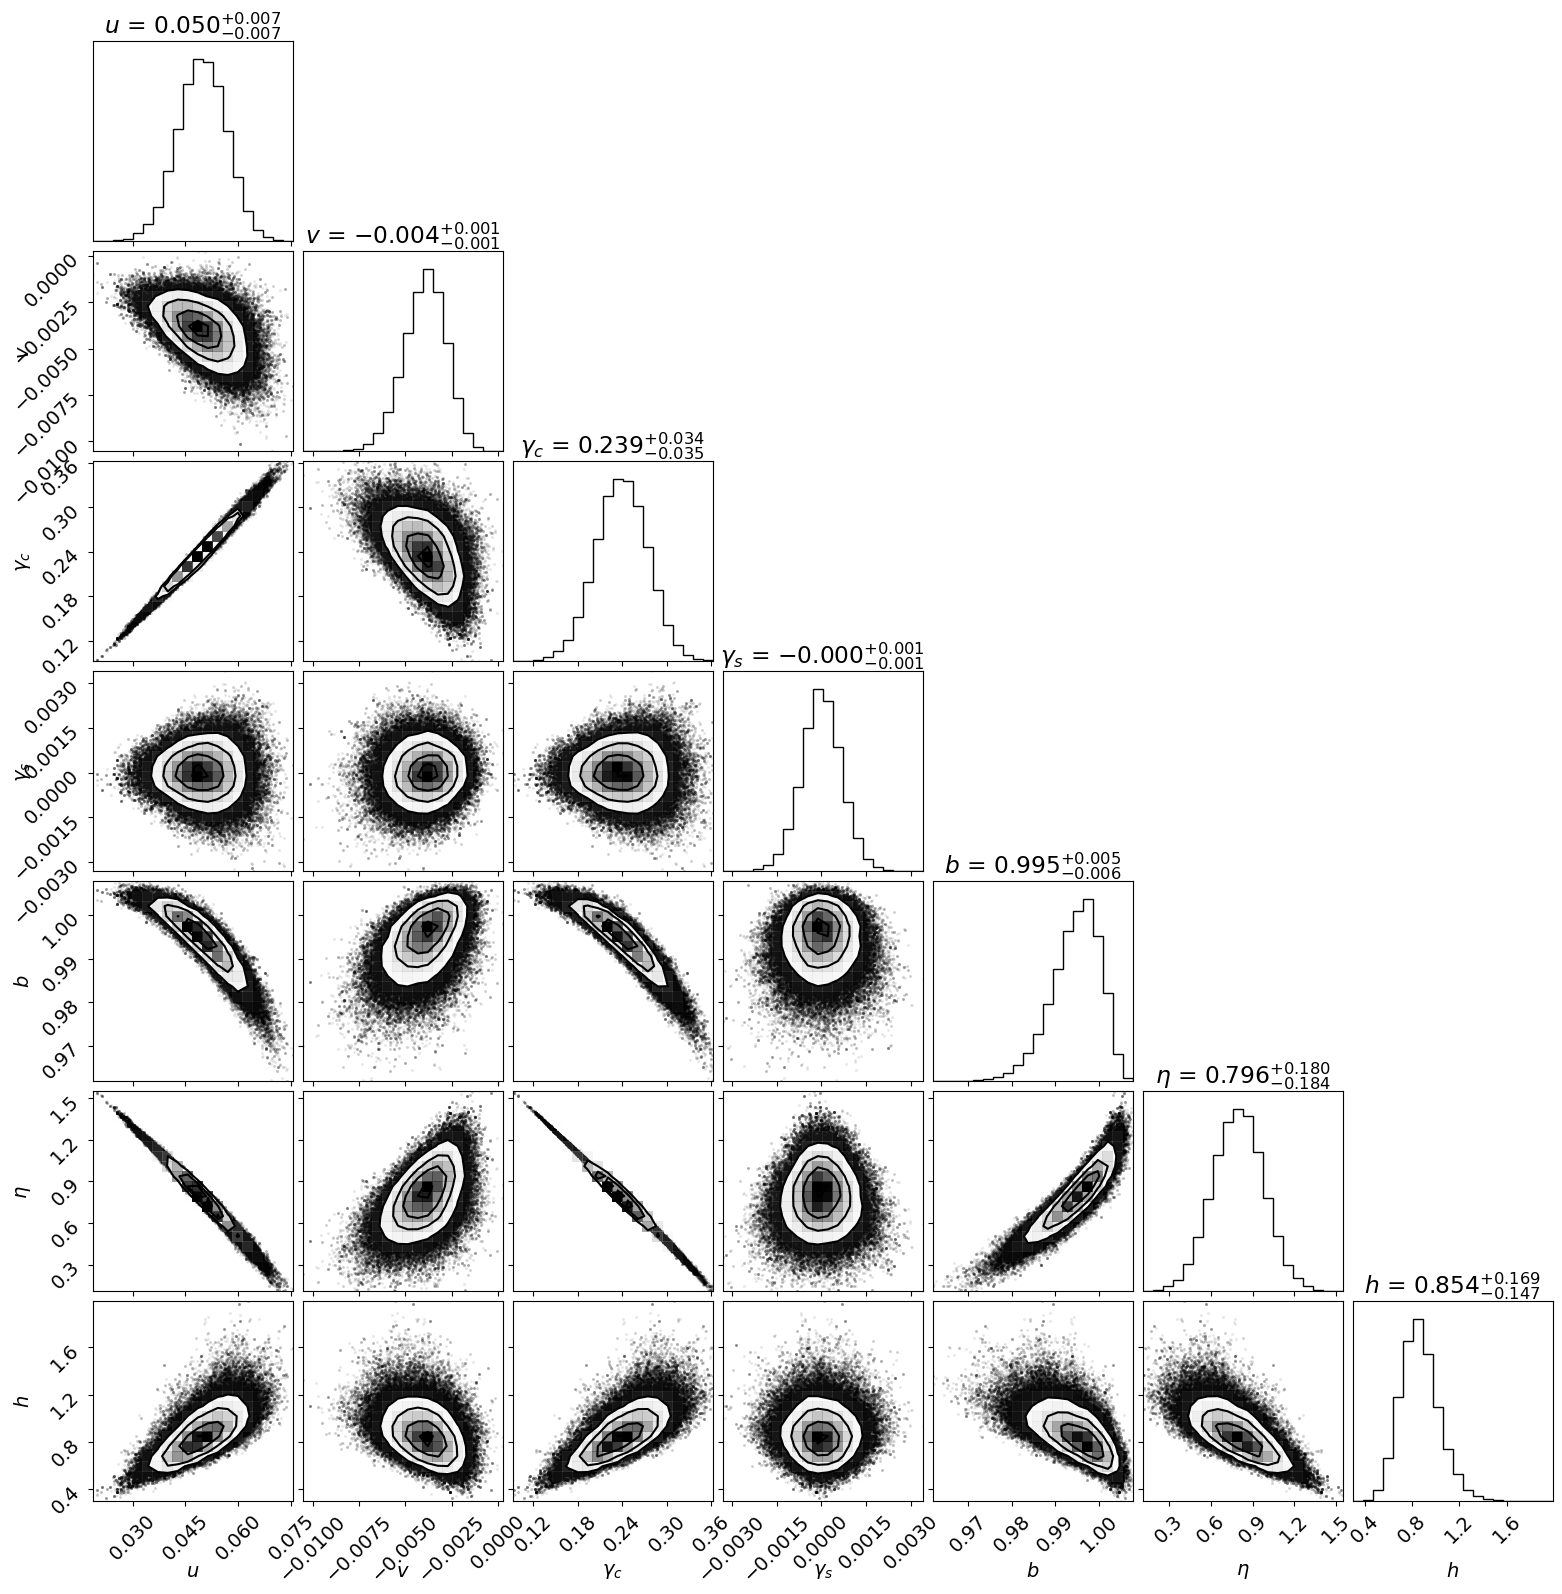

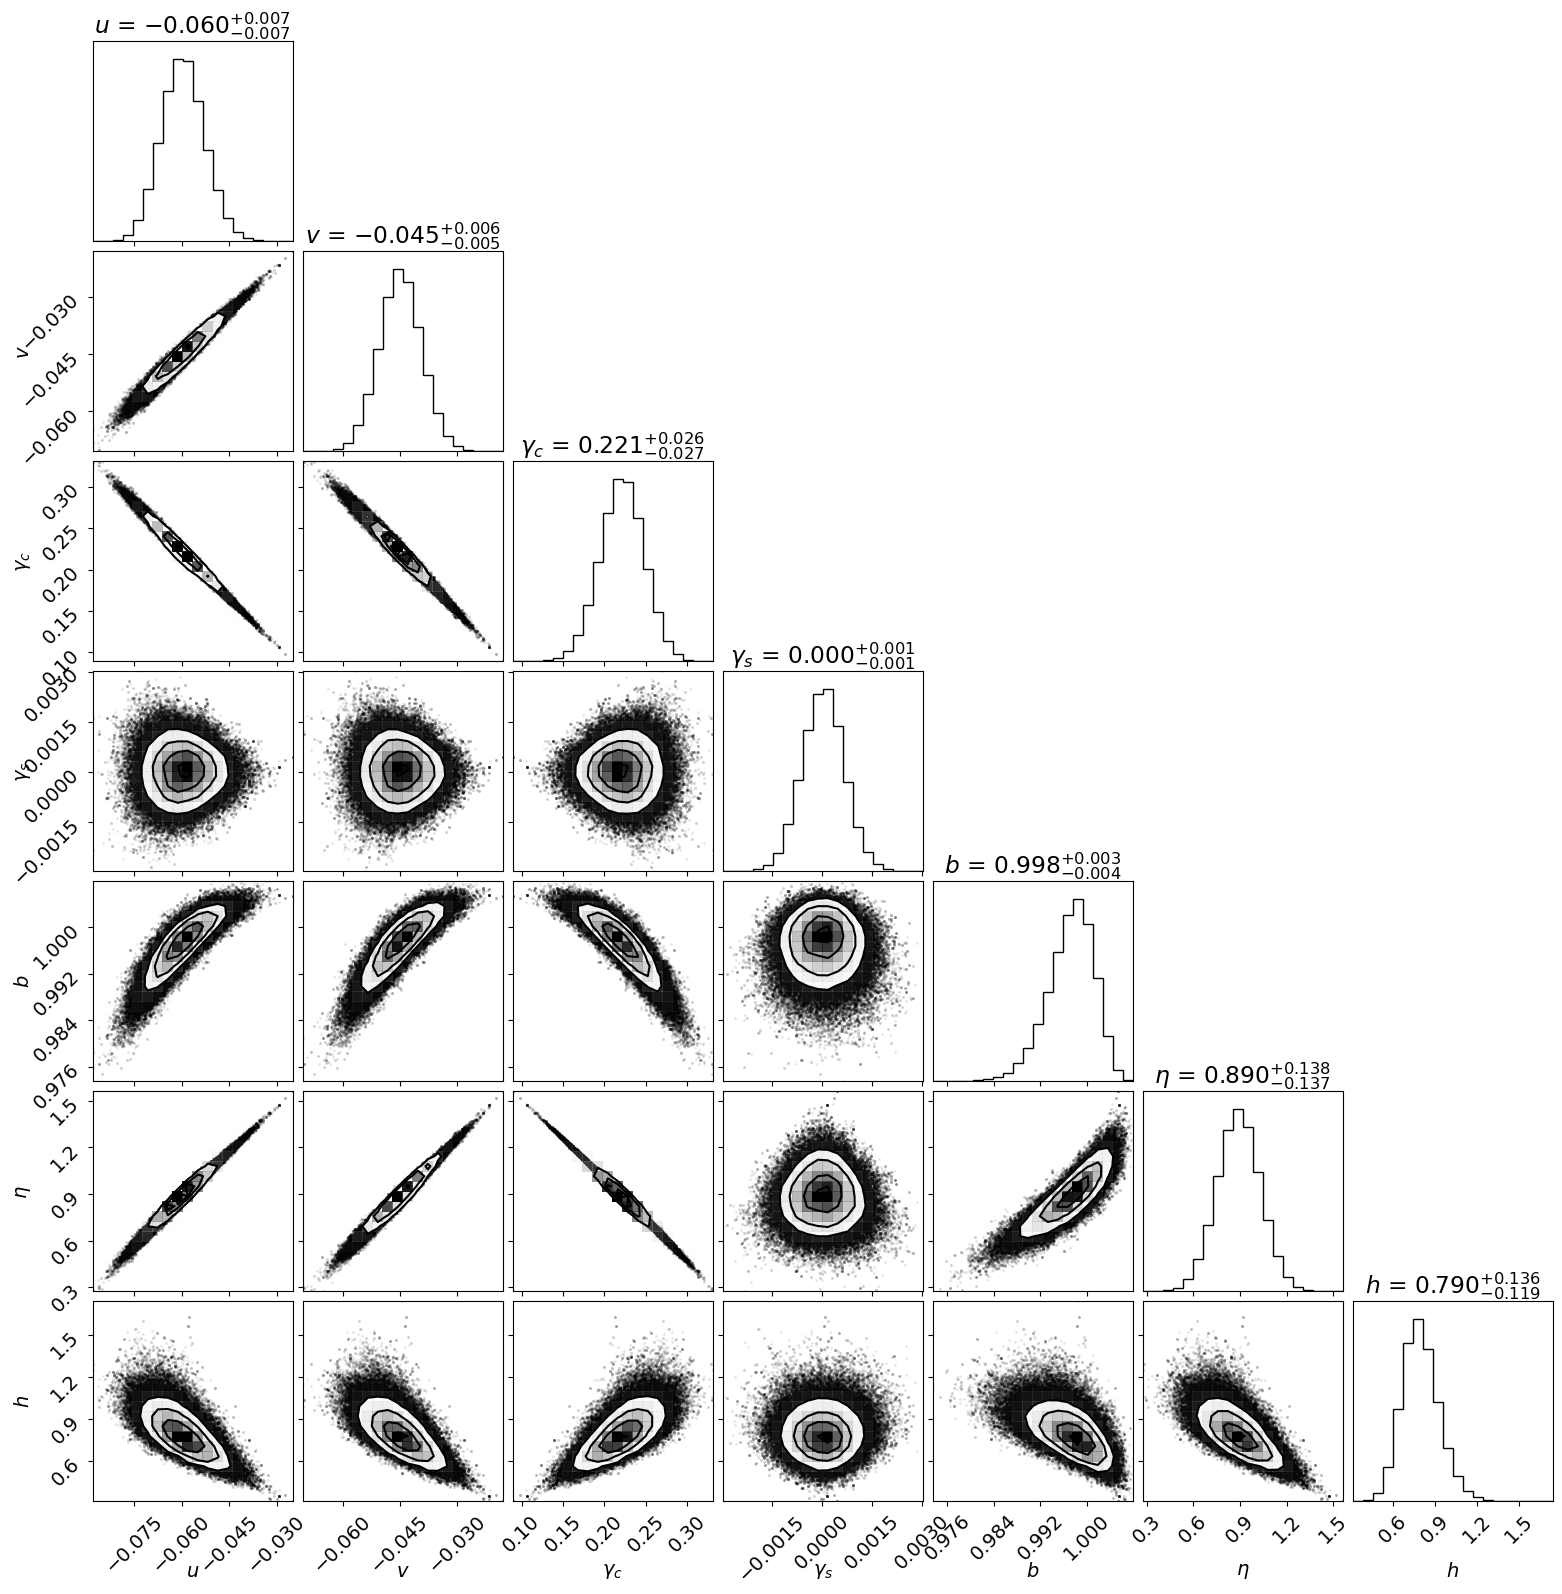

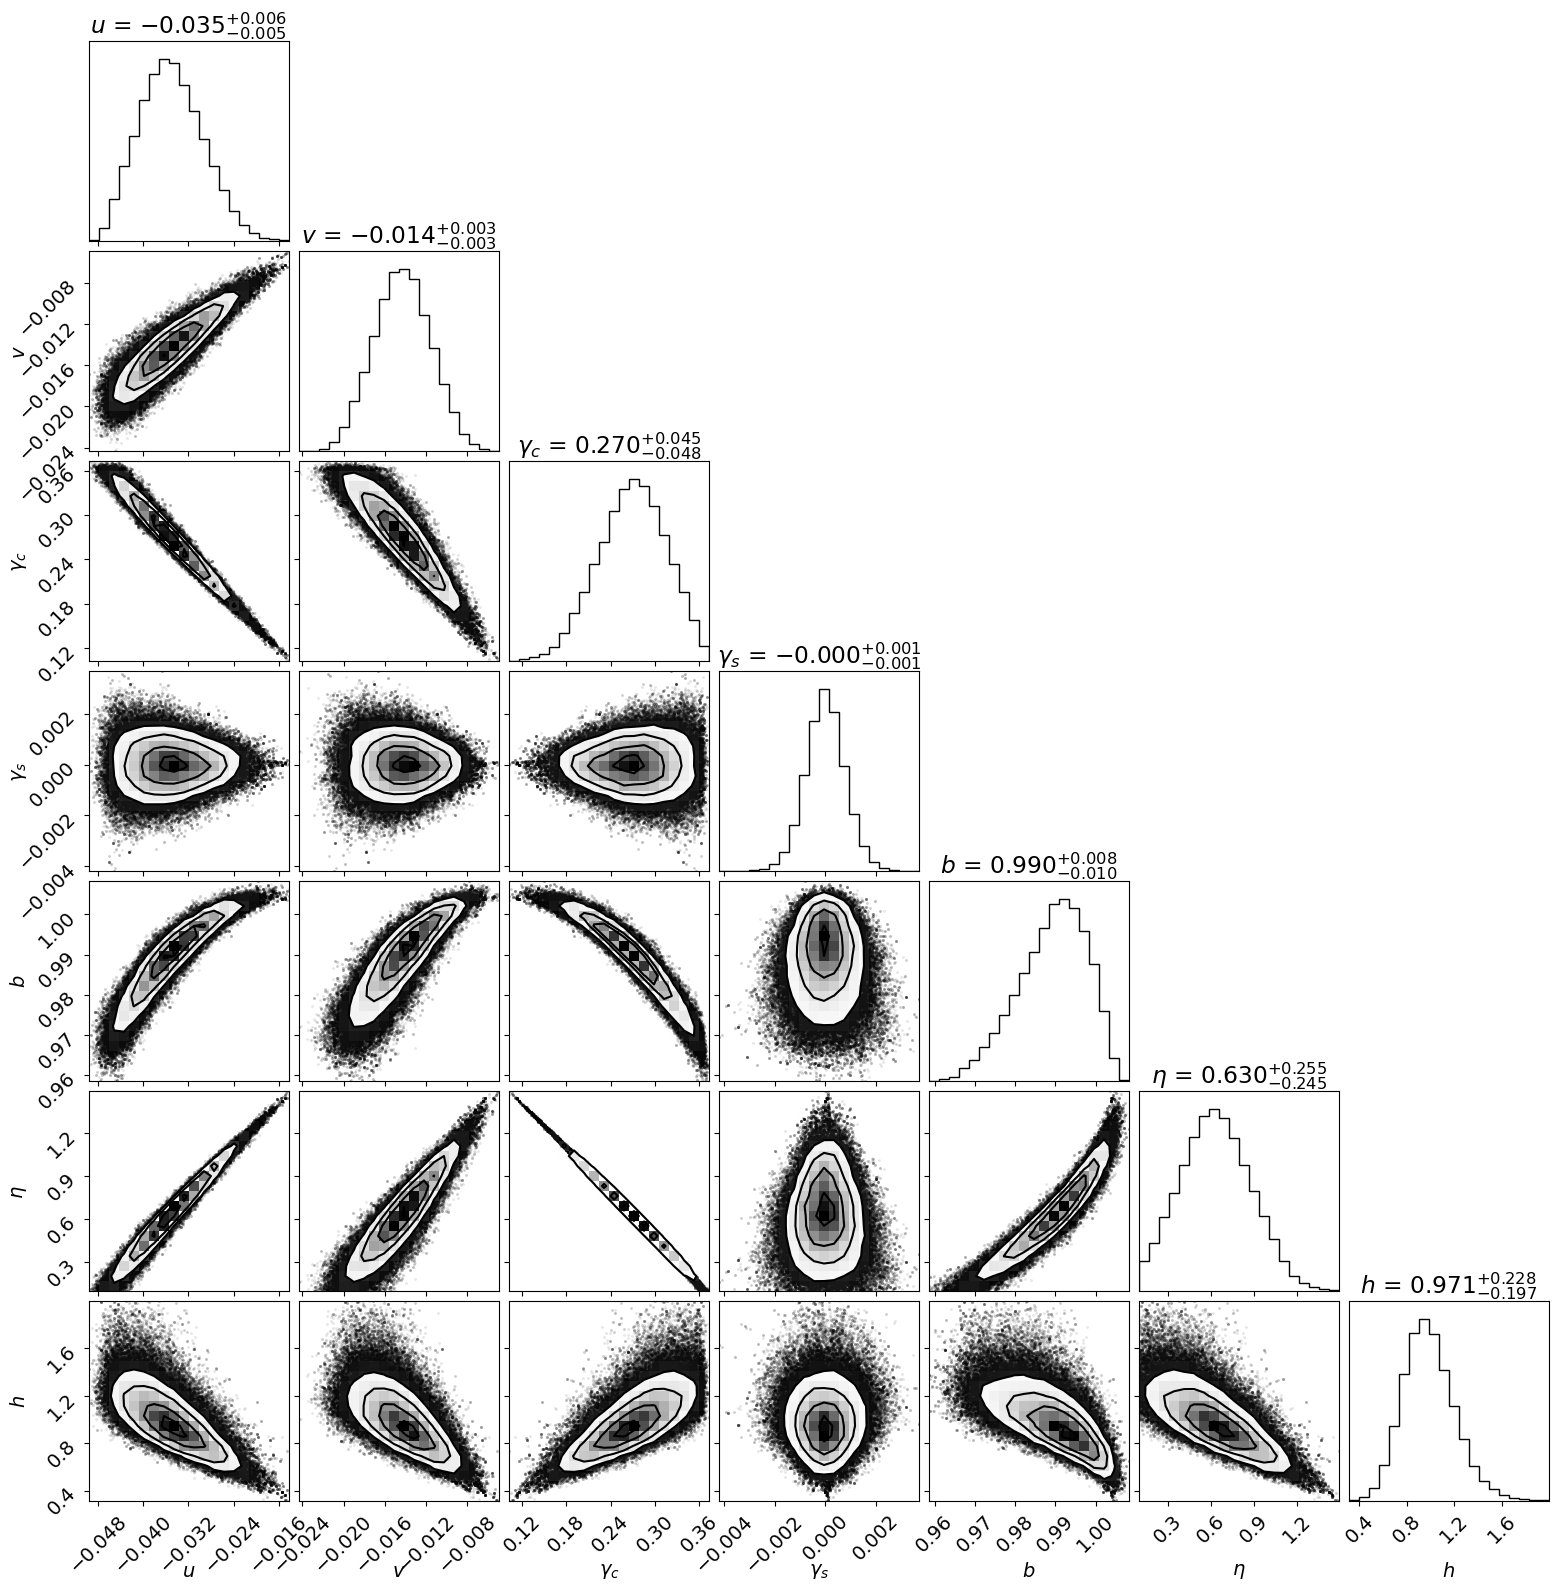

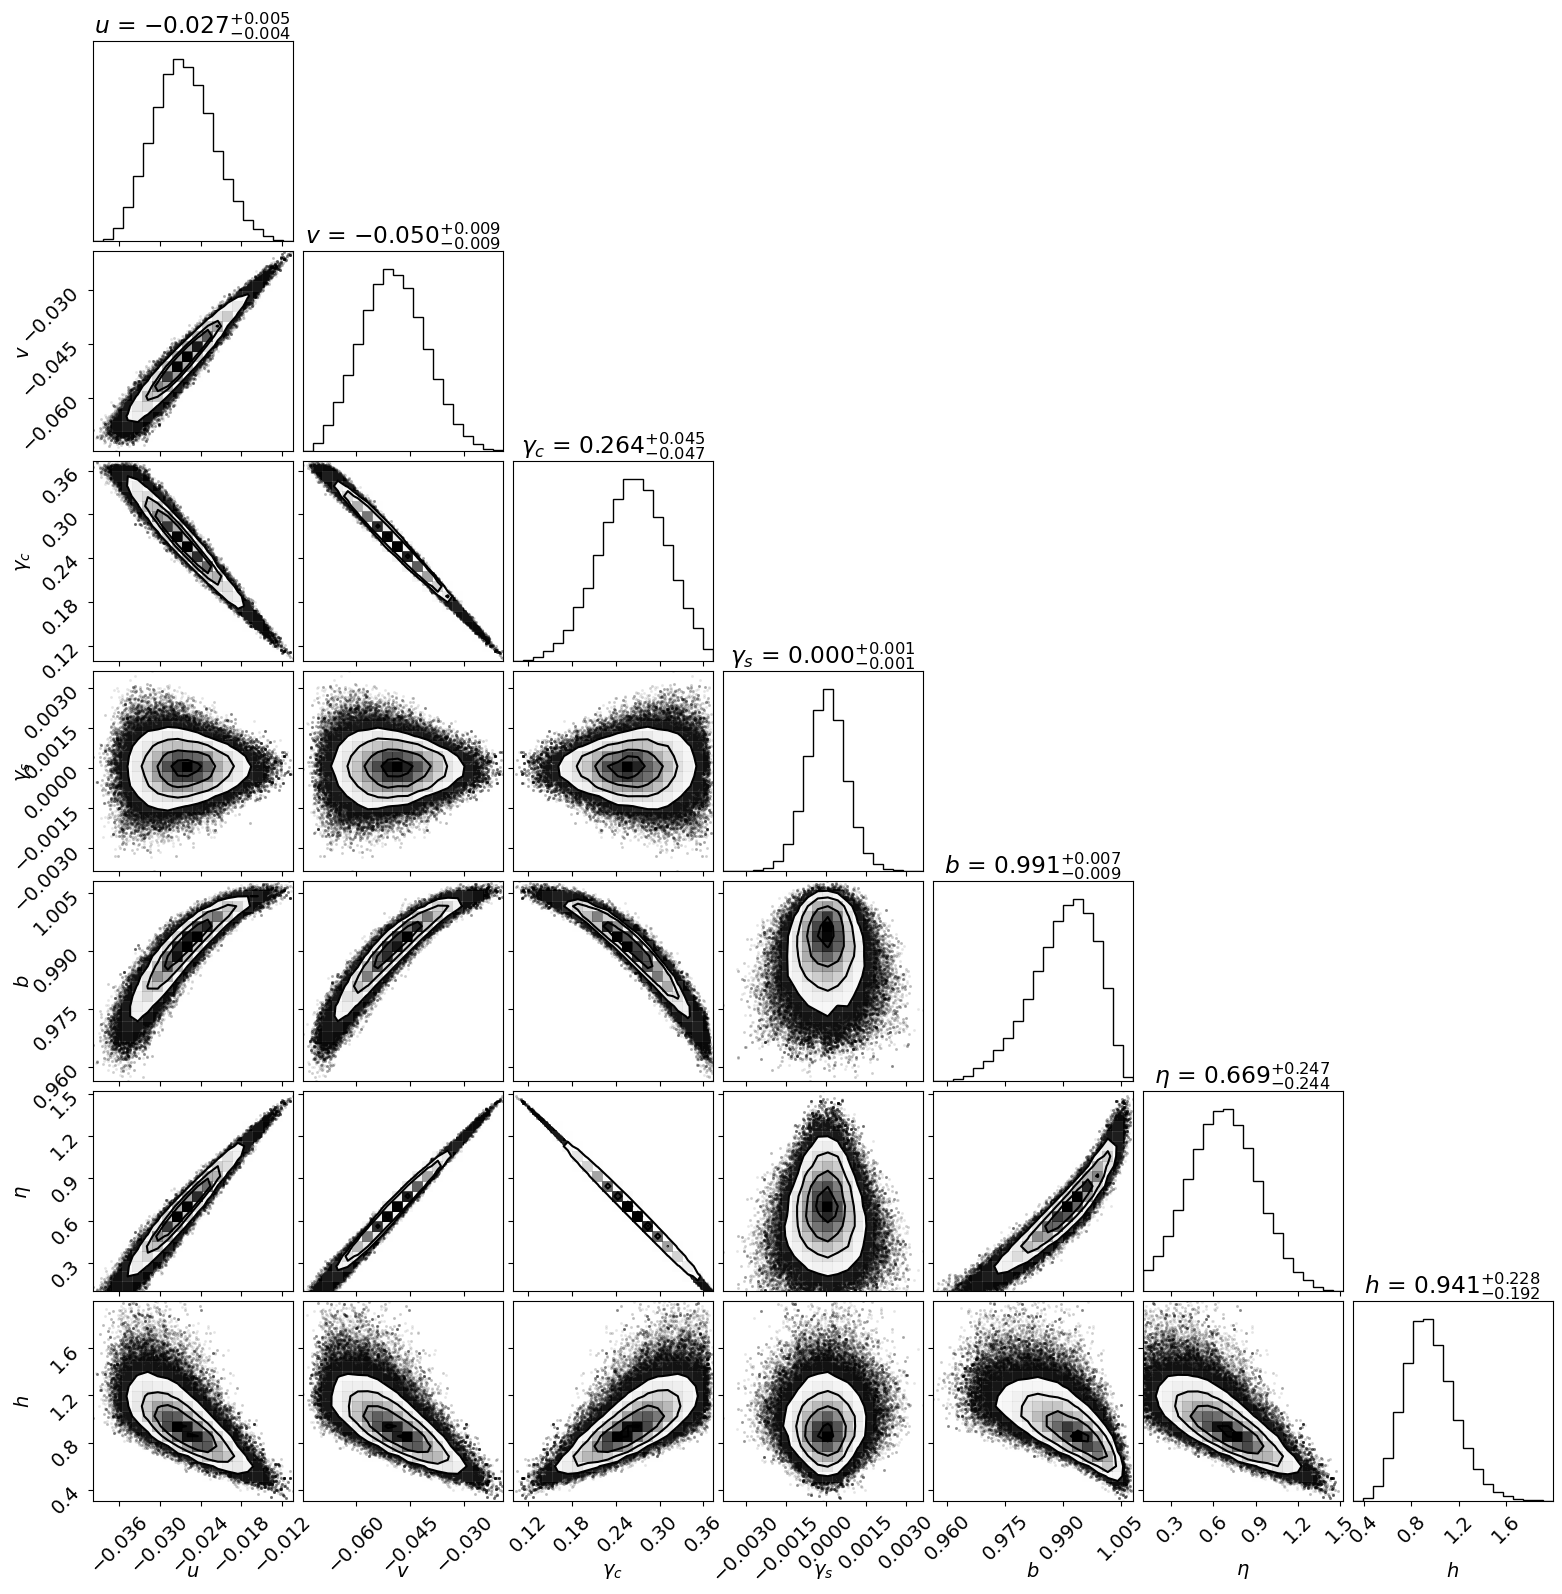

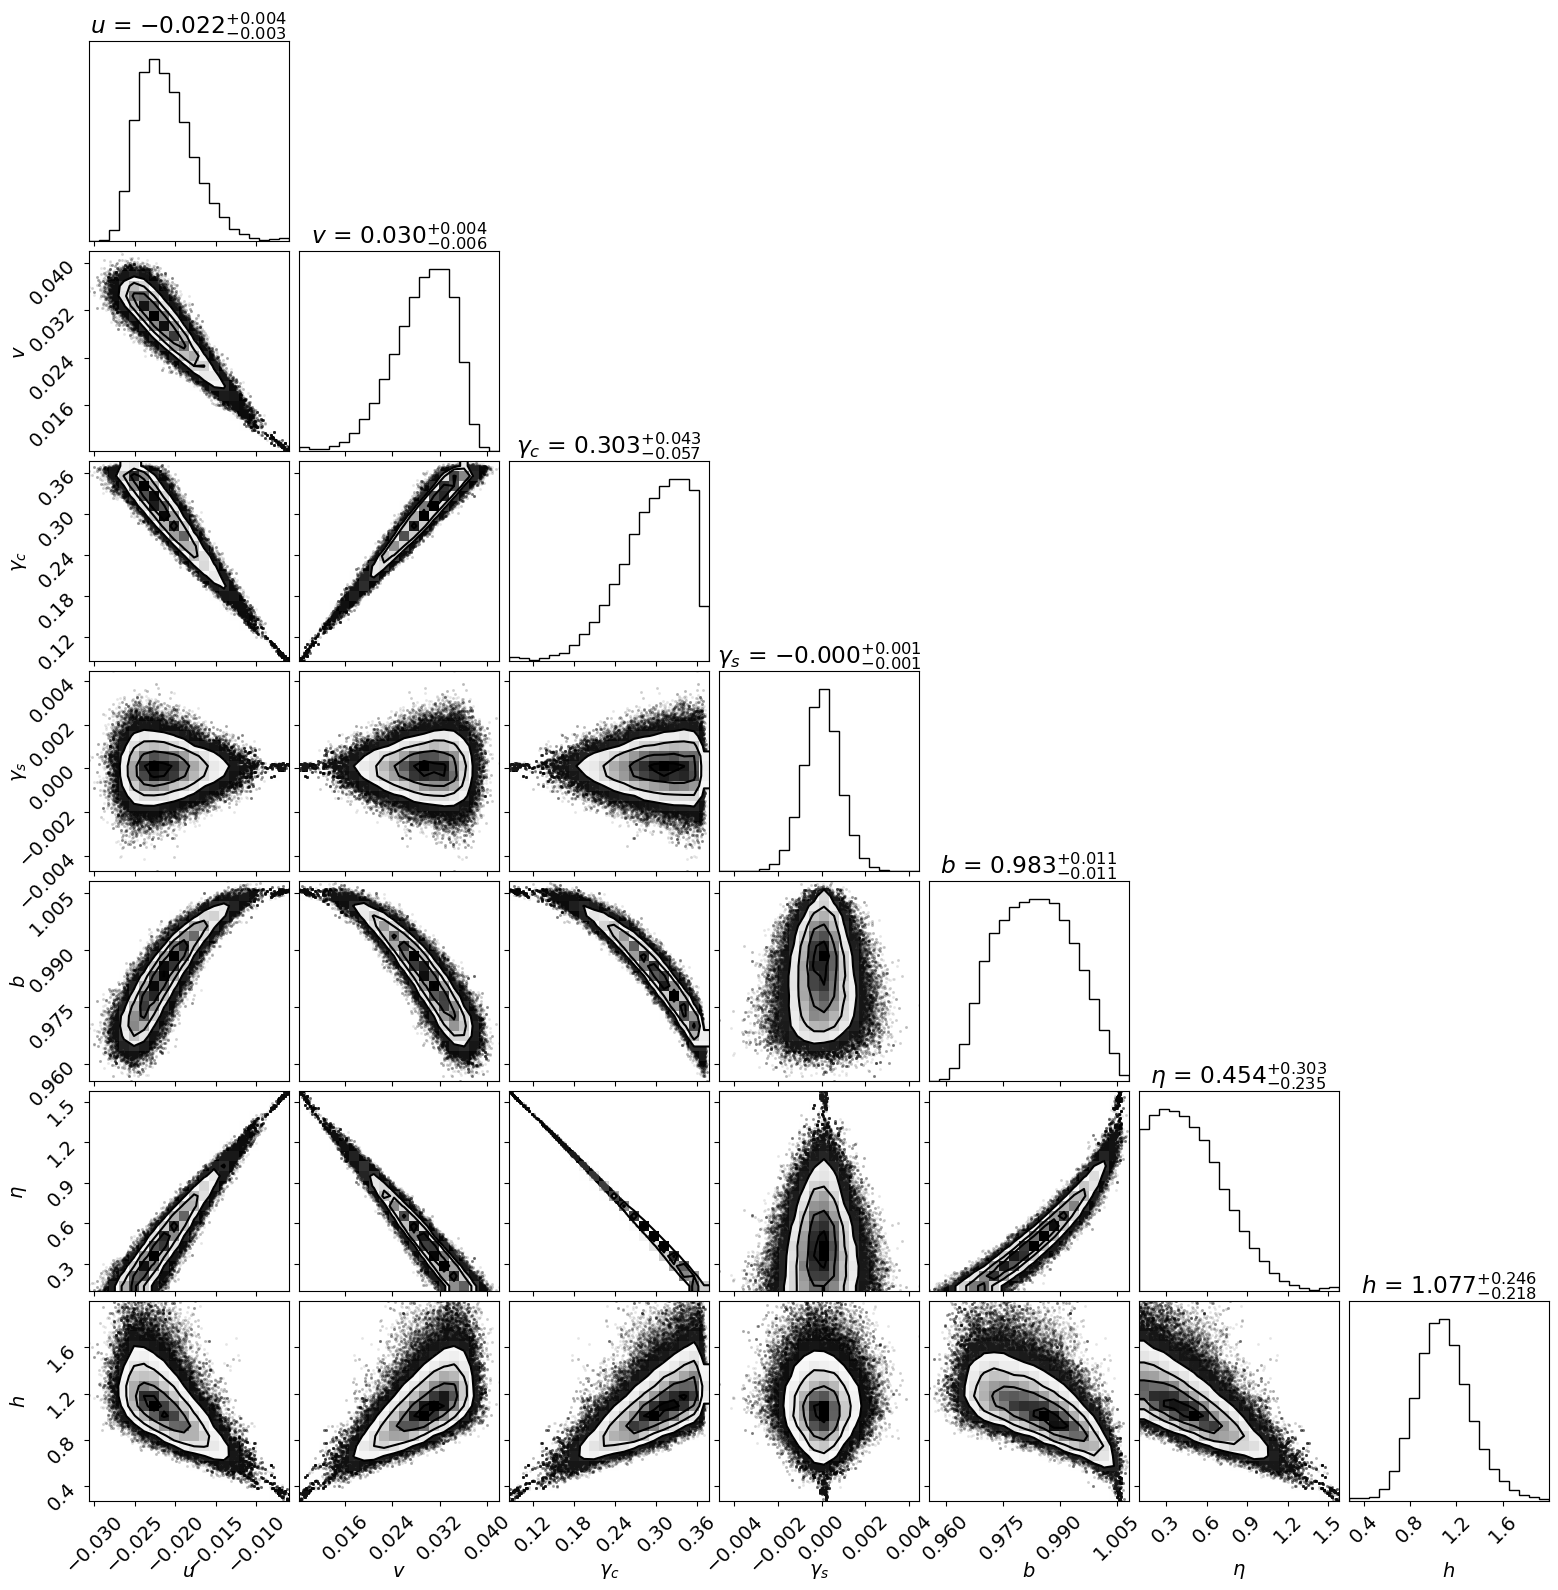

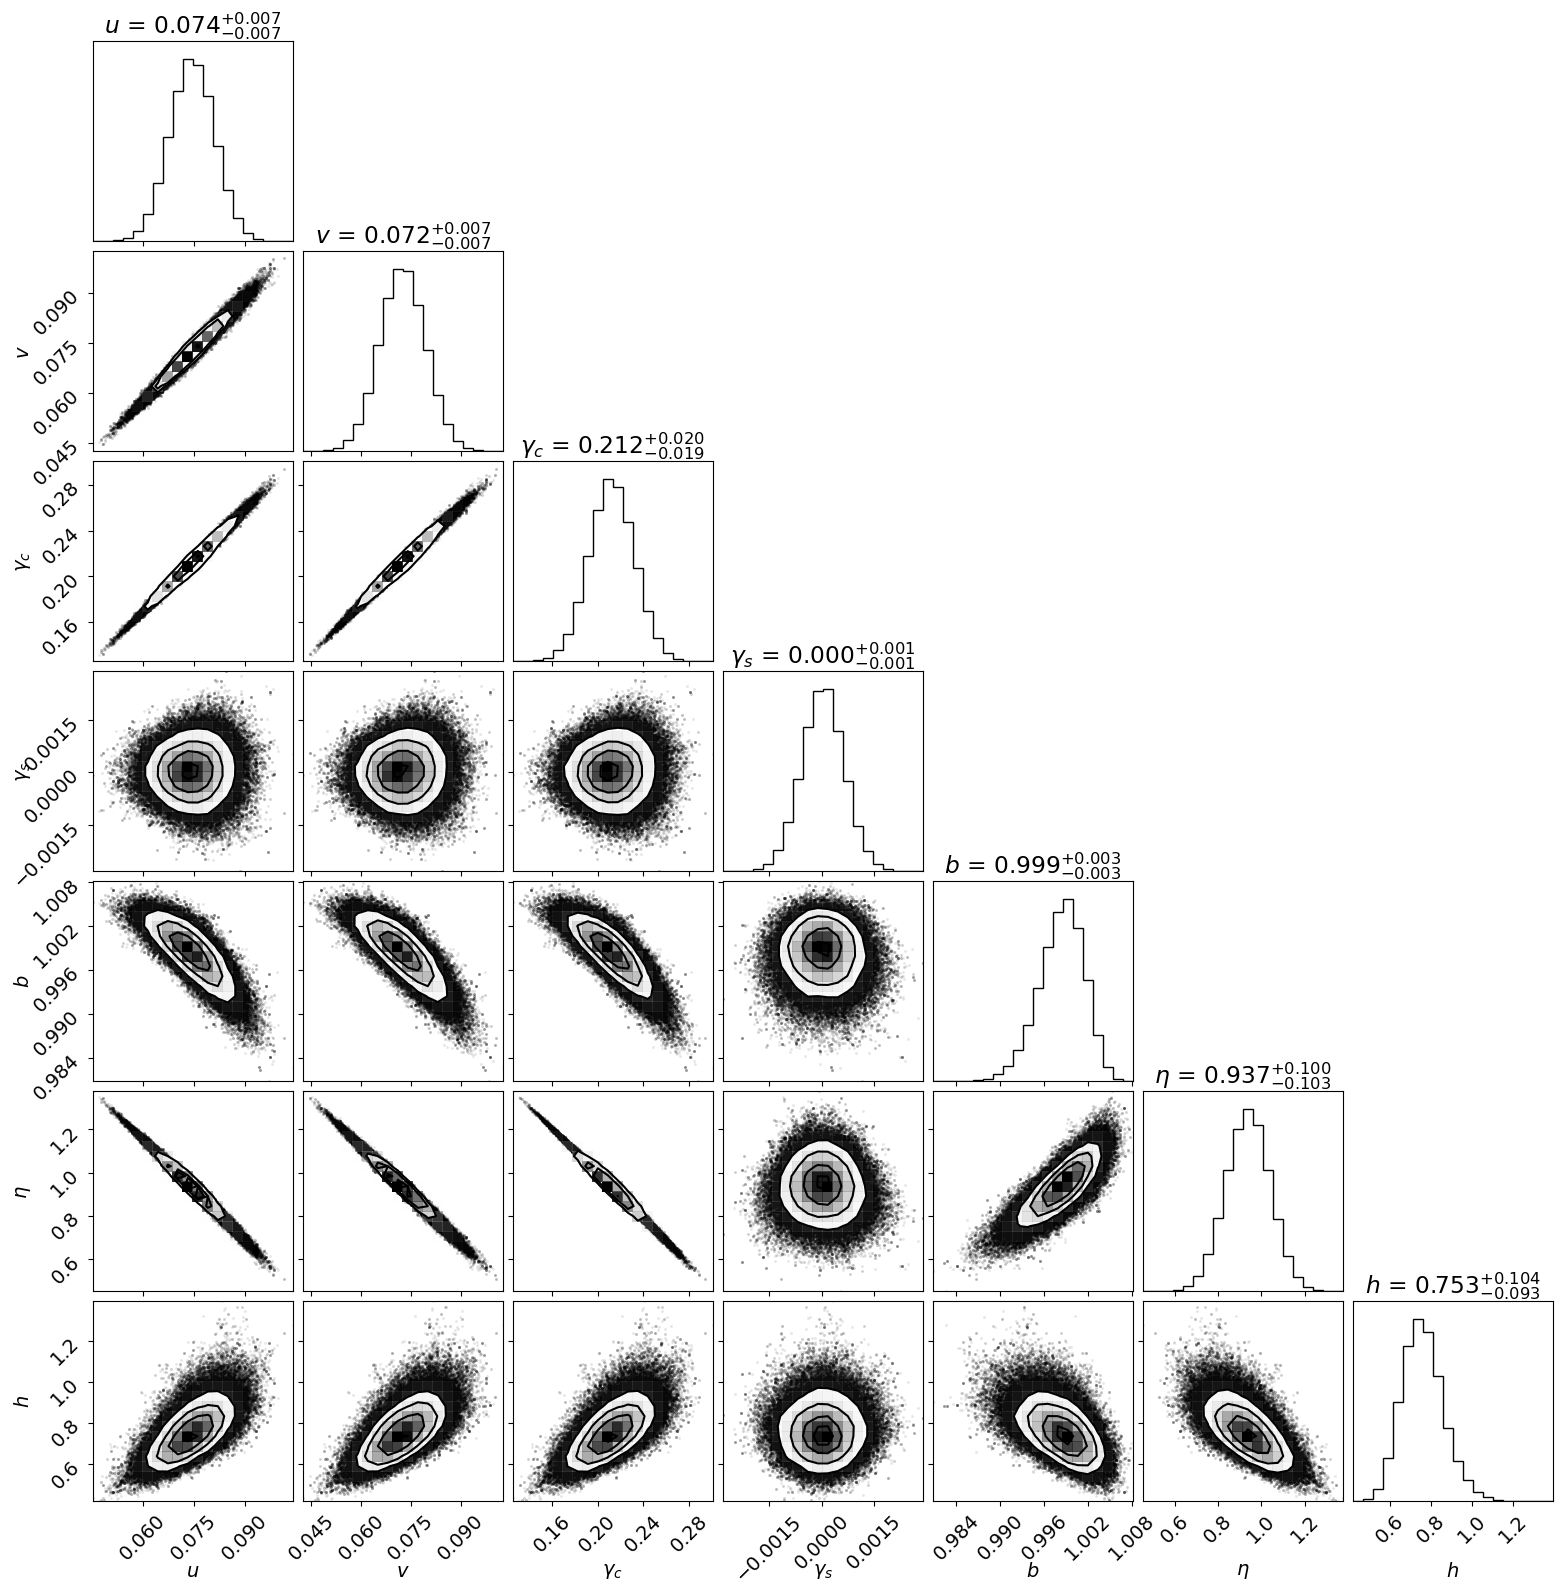

In [15]:
### RUN MCMC
for n in range(0,n_samples):
    basename=root+str(n+1)
    runlens(basename)

In [12]:
### READ INFO FROM MCMC FITS:
totalmag, peakmag, Rij, tau12, tau13, tau14, tau23, tau24, tau34, time_max, time_min, annulus_length = rel.get_info(datfiles)
h_med, h_err, eta_med, eta_err = h_eta.get_info(files, eta_tracker=1.0, increment=0.)
eta_bias = np.abs(eta_true-np.array(eta_med))
h_bias = np.abs(h_true-np.array(h_med))

totalmag, peakmag, Rij, tau12, tau13, tau14, tau23, tau24, tau34, time_max, time_min, annulus_length
h_med, h_err, eta_med, eta_err


Text(0.5, 0, '$r_{max} - r_{min}$ [arcsec]')

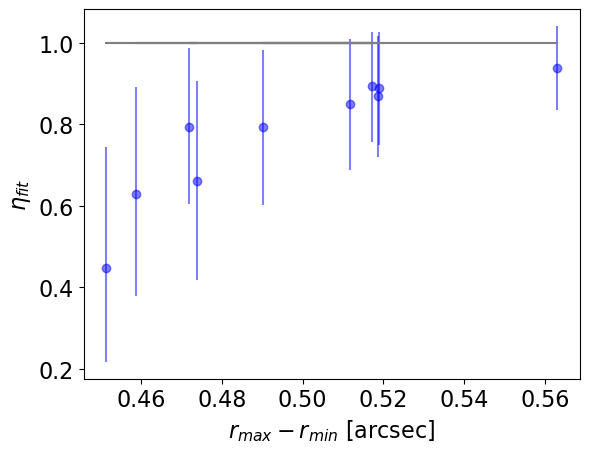

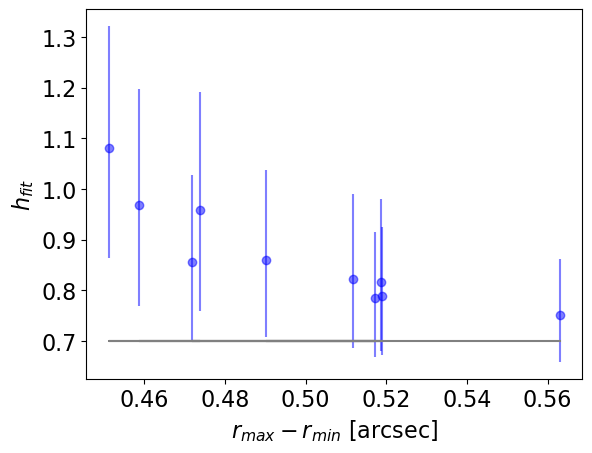

In [14]:
### PLOT MCMC BEST-FIT VALUES FOR H AND ETA AS A FUNCTION OF ANNULUS LENGTH
#############################################################
X = annulus_length
xlabel = '$r_{max} - r_{min}$ [arcsec]'
xfile = 'annulus-length'
colorr='blue'
#############################################################

bias = eta_bias
plt.figure()
plt.errorbar(X, eta_med, yerr=[ eta_err[0], eta_err[1] ], marker='o', color=colorr, linestyle='', alpha=0.5)
plt.plot(X, [eta_true]*len(X), linestyle='-', color='grey')
plt.ylabel('$\\eta_{fit}$')
plt.xlabel(xlabel)

bias = h_bias
plt.figure()
plt.errorbar(X, h_med, yerr=[ h_err[0], h_err[1] ], marker='o', linestyle='', color=colorr, alpha=0.5)
plt.plot(X, [h_true]*len(X), linestyle='-', color='grey')
plt.ylabel('$h_{fit}$')
plt.xlabel(xlabel)